# Data Migration 
Before using the database, logdata was storted to csv files into the `logs` directory. This Notebook creates a sqlite database `site.db` and writes the logdata to that file.

In [1]:
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from app import db, WalliStat, Campaign

C:\ProgramData\Anaconda3\envs\flask_env\lib\site-packages\flask_sqlalchemy\__init__.py:872: FSADeprecationWarning: SQLALCHEMY_TRACK_MODIFICATIONS adds significant overhead and will be disabled by default in the future.  Set it to True or False to suppress this warning.
  warnings.warn(FSADeprecationWarning(


In [2]:
db.create_all()

In [3]:
t = dt.datetime.now()    
next_hour = t.replace(second=0, microsecond=0, minute=0, hour=t.hour+1)
hourly = Campaign(id=0, title="hourly", start=next_hour, interval=dt.timedelta(seconds=3600))
hourly

Campaign(id:0, 'hourly' is active:None, start:2021-10-18 20:00:00, end:None, interval:1:00:00)

In [4]:
db.session.add(hourly)
db.session.commit()

In [5]:
path_ = os.path.join("..", "logs")
for fn in os.listdir(path_):
    if fn.startswith("raw_2"):
        date_str = fn.split(".")[0].split("_")[1]
        df = pd.read_csv(os.path.join(path_, fn))
        df["datetime"] = [pd.to_datetime(date_str + " " + t).to_pydatetime() for t in df["time"]]
        dscr = df["datetime"].describe()
        print(fn, dscr["count"], dscr["first"], dscr["last"])

C:\Users\holge\AppData\Local\Temp/ipykernel_9364/2225955464.py:7: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  dscr = df["datetime"].describe()


raw_2021-09-13.csv 1436 2021-09-13 00:00:46 2021-09-13 23:59:14
raw_2021-09-14.csv 1437 2021-09-14 00:00:14 2021-09-14 23:59:43
raw_2021-09-15.csv 1436 2021-09-15 00:00:44 2021-09-15 23:59:12
raw_2021-09-16.csv 1437 2021-09-16 00:00:12 2021-09-16 23:59:42
raw_2021-09-17.csv 1436 2021-09-17 00:00:42 2021-09-17 23:59:09
raw_2021-09-18.csv 1437 2021-09-18 00:00:09 2021-09-18 23:59:31
raw_2021-09-19.csv 1437 2021-09-19 00:00:31 2021-09-19 23:59:53
raw_2021-09-20.csv 1436 2021-09-20 00:00:53 2021-09-20 23:59:15
raw_2021-09-21.csv 1437 2021-09-21 00:00:15 2021-09-21 23:59:37
raw_2021-09-22.csv 1436 2021-09-22 00:00:37 2021-09-22 23:58:59
raw_2021-09-23.csv 1437 2021-09-23 00:00:00 2021-09-23 23:59:22
raw_2021-09-24.csv 1437 2021-09-24 00:00:22 2021-09-24 23:59:45
raw_2021-09-25.csv 1436 2021-09-25 00:00:45 2021-09-25 23:59:09
raw_2021-09-26.csv 1437 2021-09-26 00:00:09 2021-09-26 23:59:32
raw_2021-09-27.csv 1437 2021-09-27 00:00:32 2021-09-27 23:59:54
raw_2021-09-28.csv 1436 2021-09-28 00:00

## Try resampling on one example logfile

In [6]:
fn = "raw_2021-10-09.csv"
date_str = fn.split(".")[0].split("_")[1]
df = pd.read_csv(os.path.join("..", "logs", fn))
df["datetime"] = [pd.to_datetime(date_str + " " + t).to_pydatetime() for t in df["time"]]
df.head(7)

,time,ver,charge_state,I_L1,I_L2,I_L3,Temp,V_L1,V_L2,V_L3,...,E_hb,E_lb,I_max,I_min,watchdog,standby,remote_lock,max_I_cmd,FailSafe_I,datetime
0,00:00:57,264,2,0,0,0,197,236,237,239,...,5,33195,10,6,15000,4,1,100,100,2021-10-09 00:00:57
1,00:01:57,264,2,0,0,0,197,237,237,239,...,5,33195,10,6,15000,4,1,100,100,2021-10-09 00:01:57
2,00:02:57,264,2,0,0,0,197,237,237,239,...,5,33195,10,6,15000,4,1,100,100,2021-10-09 00:02:57
3,00:03:57,264,2,0,0,0,197,237,237,239,...,5,33195,10,6,15000,4,1,100,100,2021-10-09 00:03:57
4,00:04:58,264,2,0,0,0,197,237,237,239,...,5,33195,10,6,15000,4,1,100,100,2021-10-09 00:04:58
5,00:05:58,264,2,0,0,0,197,235,236,237,...,5,33195,10,6,15000,4,1,100,100,2021-10-09 00:05:58
6,00:06:58,264,2,0,0,0,197,237,237,239,...,5,33195,10,6,15000,4,1,100,100,2021-10-09 00:06:58


In [7]:
lowres = df.set_index("datetime").resample(dt.timedelta(seconds=3600)).first()
lowres.shape

(24, 23)

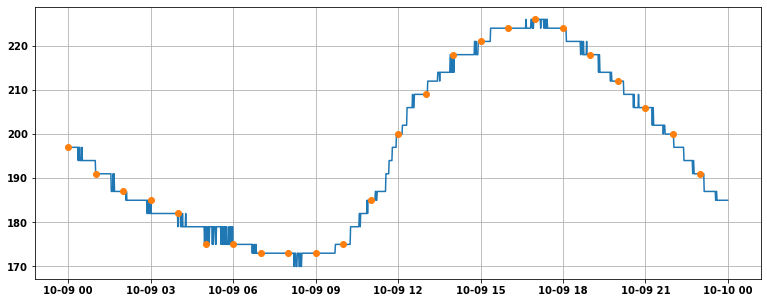

In [8]:
plt.figure(figsize=(13,5))
plt.plot(df["datetime"], df["Temp"])
plt.plot(lowres.index, lowres["Temp"], "o")
plt.grid();

## Resample on all logfiles

In [9]:
highres = pd.DataFrame()
path_ = os.path.join("..", "logs")
for fn in os.listdir(path_):
    if fn.startswith("raw_2"):
        print(".", end="")
        date_str = fn.split(".")[0].split("_")[1]
        df = pd.read_csv(os.path.join(path_, fn))
        df["datetime"] = [pd.to_datetime(date_str + " " + t).to_pydatetime() for t in df["time"]]
        df.drop("time", axis=1, inplace=True)
        highres = pd.concat([highres, df], ignore_index=True)
highres.shape

............................

(39470, 23)

In [10]:
highres.set_index("datetime", inplace=True)
highres.shape


(39470, 22)

In [11]:
lowres = highres.resample(dt.timedelta(seconds=3600)).first()
lowres.shape

(660, 22)

Some plausibility plots

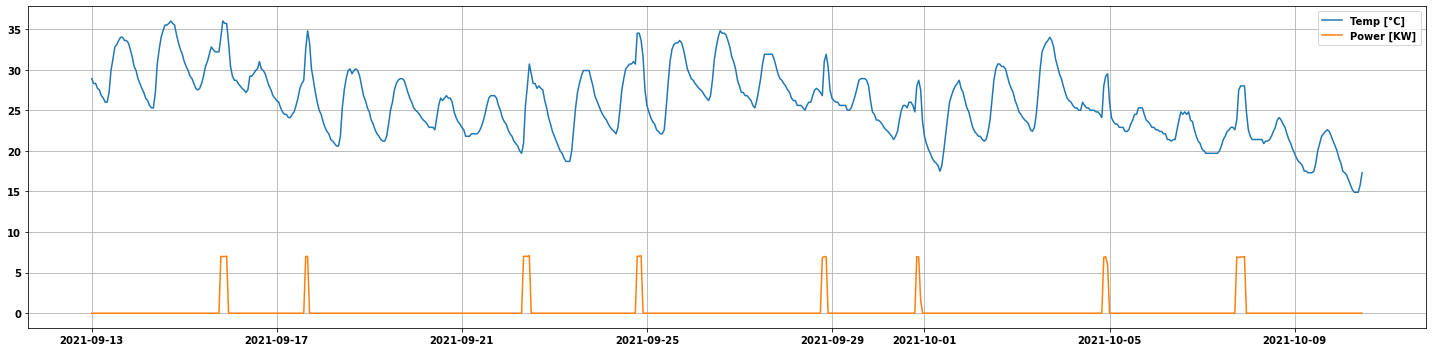

In [12]:
plt.figure(figsize=(20,5))
plt.plot(lowres.index, lowres["Temp"]/10., label="Temp [°C]")
plt.plot(lowres.index, lowres["P"]/1000., label="Power [KW]")
plt.grid(), plt.legend(), plt.tight_layout();

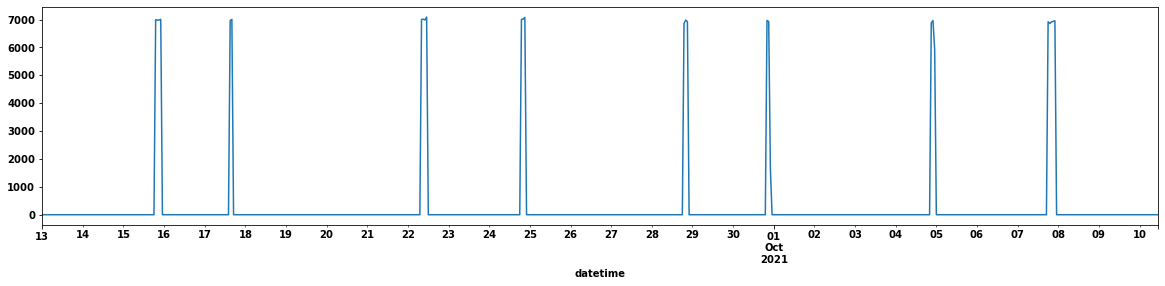

In [13]:
lowres["P"].plot(figsize=(20,4));

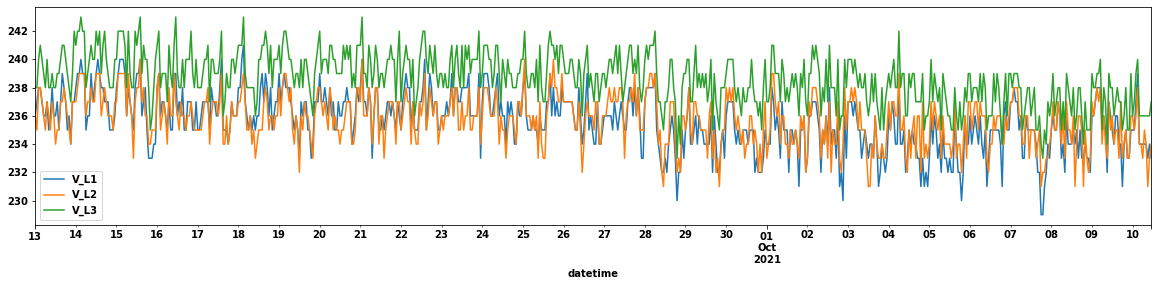

In [14]:
lowres[["V_L1", "V_L2", "V_L3"]].plot(figsize=(20,4));

In [18]:
lowres.charge_state.value_counts()

2    554
5     79
7     27
Name: charge_state, dtype: int64

## Write lowres data to database ``site.db``

In [15]:
df.columns

Index(['ver', 'charge_state', 'I_L1', 'I_L2', 'I_L3', 'Temp', 'V_L1', 'V_L2',
       'V_L3', 'ext_lock', 'P', 'E_cyc_hb', 'E_cyc_lb', 'E_hb', 'E_lb',
       'I_max', 'I_min', 'watchdog', 'standby', 'remote_lock', 'max_I_cmd',
       'FailSafe_I', 'datetime'],
      dtype='object')

In [16]:
for index, row in lowres.iterrows():
    wst = WalliStat(datetime = index, 
                    charging_state = int(row.charge_state), 
                    I_L1 = row.I_L1 / 10.,
                    I_L2 = row.I_L2 / 10.,
                    I_L3 = row.I_L3 / 10.,
                    temperature = row.Temp / 10.,
                    V_L1 = int(row.V_L1),
                    V_L2 = int(row.V_L2),
                    V_L3 = int(row.V_L3),
                    extern_lock_state = int(row.ext_lock),
                    power = int(row.P),
                    energy_pwr_on = int((row.E_cyc_hb << 16) + row.E_cyc_lb),
                    energy_total = int((row.E_hb << 16) + row.E_lb),
                    I_max_cfg = int(row.I_max),
                    I_min_cfg = int(row.I_max),
                    modbus_watchdog_timeout = int(row.watchdog),
                    remote_lock = int(row.remote_lock),
                    I_max_cmd = int(row.max_I_cmd),
                    I_fail_safe = int(row.FailSafe_I), 
                    campaign = hourly)
    db.session.add(wst)
db.session.commit()